# Importing Data and Libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
con = sqlite3.connect('data/im.db')
cur = con.cursor()

In [3]:
bmg = pd.read_csv('data/bom.movie_gross.csv')
mb = pd.read_csv('data/tn.movie_budgets.csv')
m = pd.read_csv('data/tmdb.movies.csv')

In [4]:
rv = pd.read_csv('data/rt.reviews.tsv', delimiter = '\t', encoding = 'latin') 
# needed to change the encoding as it was throwing an error message about it
# tsv file, so needed to add a delimiter of tab

In [5]:
mi = pd.read_csv('data/rt.movie_info.tsv', delimiter = '\t')

In [6]:
imdb_rated = pd.read_csv('data/IMDB_rated_only.csv')

# Exploring the im.db Data

In [7]:
%%bash

sqlite3 data/im.db
.tables

#checking the table names

directors      movie_akas     movie_ratings  principals   
known_for      movie_basics   persons        writers      


In [8]:
%%bash

sqlite3 data/im.db
.schema

#checking schema

CREATE TABLE IF NOT EXISTS "movie_basics" (
"movie_id" TEXT,
  "primary_title" TEXT,
  "original_title" TEXT,
  "start_year" INTEGER,
  "runtime_minutes" REAL,
  "genres" TEXT
);
CREATE TABLE IF NOT EXISTS "directors" (
"movie_id" TEXT,
  "person_id" TEXT
);
CREATE TABLE IF NOT EXISTS "known_for" (
"person_id" TEXT,
  "movie_id" TEXT
);
CREATE TABLE IF NOT EXISTS "movie_akas" (
"movie_id" TEXT,
  "ordering" INTEGER,
  "title" TEXT,
  "region" TEXT,
  "language" TEXT,
  "types" TEXT,
  "attributes" TEXT,
  "is_original_title" REAL
);
CREATE TABLE IF NOT EXISTS "movie_ratings" (
"movie_id" TEXT,
  "averagerating" REAL,
  "numvotes" INTEGER
);
CREATE TABLE IF NOT EXISTS "persons" (
"person_id" TEXT,
  "primary_name" TEXT,
  "birth_year" REAL,
  "death_year" REAL,
  "primary_profession" TEXT
);
CREATE TABLE IF NOT EXISTS "principals" (
"movie_id" TEXT,
  "ordering" INTEGER,
  "person_id" TEXT,
  "category" TEXT,
  "job" TEXT,
  "characters" TEXT
);
CREATE TABLE IF NOT EXISTS "writers" (
"m

In [9]:
query_result = pd.read_sql('''
    SELECT *
    FROM 
        movie_ratings AS mr 
        INNER JOIN movie_basics AS mb
            ON mb.movie_id = mr.movie_id
    
    ORDER BY "averagerating" DESC

    LIMIT 50
    
''', con)

query_result

,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt5390098,10.0,5,tt5390098,The Paternal Bond: Barbary Macaques,Atlas Mountain: Barbary Macaques - Childcaring...,2015,59.0,Documentary
1,tt6295832,10.0,5,tt6295832,Requiem voor een Boom,Requiem voor een Boom,2016,48.0,Documentary
2,tt1770682,10.0,5,tt1770682,Freeing Bernie Baran,Freeing Bernie Baran,2010,100.0,"Crime,Documentary"
3,tt2632430,10.0,5,tt2632430,Hercule contre Hermès,Hercule contre Hermès,2012,72.0,Documentary
4,tt8730716,10.0,5,tt8730716,Pick It Up! - Ska in the '90s,Pick It Up! - Ska in the '90s,2019,99.0,Documentary
5,tt4960818,10.0,8,tt4960818,Revolution Food,Revolution Food,2015,70.0,Documentary
6,tt6991826,10.0,5,tt6991826,A Dedicated Life: Phoebe Brand Beyond the Group,A Dedicated Life: Phoebe Brand Beyond the Group,2015,93.0,Documentary
7,tt10176328,10.0,5,tt10176328,Exteriores: Mulheres Brasileiras na Diplomacia,Exteriores: Mulheres Brasileiras na Diplomacia,2018,52.0,Documentary
8,tt4944240,10.0,5,tt4944240,Dog Days in the Heartland,Dog Days in the Heartland,2017,NaN,Drama
9,tt5089804,10.0,7,tt5089804,Fly High: Story of the Disc Dog,Fly High: Story of the Disc Dog,2019,65.0,Documentary


In [10]:
query_result = pd.read_sql('''
    SELECT DISTINCT *
    FROM directors, movie_akas, movie_ratings, principals,  
          known_for, movie_basics, persons, writers 
    LIMIT 5
''', con)

query_result

,movie_id,person_id,movie_id,ordering,title,region,language,types,attributes,is_original_title,...,start_year,runtime_minutes,genres,person_id,primary_name,birth_year,death_year,primary_profession,movie_id,person_id
0,tt0285252,nm0899854,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0,...,2013,175.0,"Action,Crime,Drama",nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer",tt0285252,nm0899854
1,tt0285252,nm0899854,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0,...,2013,175.0,"Action,Crime,Drama",nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer",tt0438973,nm0175726
2,tt0285252,nm0899854,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0,...,2013,175.0,"Action,Crime,Drama",nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer",tt0438973,nm1802864
3,tt0285252,nm0899854,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0,...,2013,175.0,"Action,Crime,Drama",nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer",tt0462036,nm1940585
4,tt0285252,nm0899854,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0,...,2013,175.0,"Action,Crime,Drama",nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer",tt0835418,nm0310087


In [11]:
con.close()

# Cleaning CSV files

In [12]:
bmg = bmg.reset_index()

In [13]:
bmg['foreign_gross'] = bmg['foreign_gross'].str.replace(',','')

In [14]:
bmg['foreign_gross'] = bmg['foreign_gross'].astype(float)

In [15]:
mb['domestic_gross'] = mb['domestic_gross'].str.replace('$','')
mb['domestic_gross'] = mb['domestic_gross'].str.replace(',','')
mb['domestic_gross'] = mb['domestic_gross'].astype(int)

In [16]:
mb['worldwide_gross'] = mb['worldwide_gross'].str.replace('$','')

In [17]:
mb['worldwide_gross'] = mb['worldwide_gross'].str.replace(',','')

In [18]:
mb['worldwide_gross'] = mb['worldwide_gross'].astype(int)

In [19]:
mb['foreign_gross'] = mb['worldwide_gross'] - mb['domestic_gross']

In [20]:
mb['release_date'] = pd.to_datetime(mb['release_date'])

In [21]:
mb['release_year'] = mb['release_date'].dt.year

In [22]:
m['release_date'] = pd.to_datetime(m['release_date'])

In [23]:
mb['release_year'] = mb['release_date'].dt.year

In [24]:
m['release_year'] = m['release_date'].dt.year

In [25]:
print(bmg['year'].dtype)

int64


# Exploring the Movie Gross file

In [26]:
bmg.info()
# looks like foreign_gross is a string when it should be an integer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           3387 non-null   int64  
 1   title           3387 non-null   object 
 2   studio          3382 non-null   object 
 3   domestic_gross  3359 non-null   float64
 4   foreign_gross   2037 non-null   float64
 5   year            3387 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 158.9+ KB


In [27]:
bmg.isna().sum()
#foreign gross has a ton of null values

index                0
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [28]:
mb.notna().sum()

id                   5782
release_date         5782
movie                5782
production_budget    5782
domestic_gross       5782
worldwide_gross      5782
foreign_gross        5782
release_year         5782
dtype: int64

# Exploring Movie Budgets file

In [29]:
mb.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,release_year
0,1,2009-12-18,Avatar,"$425,000,000",760507625,2776345279,2015837654,2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000",241063875,1045663875,804600000,2011
2,3,2019-06-07,Dark Phoenix,"$350,000,000",42762350,149762350,107000000,2019
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000",459005868,1403013963,944008095,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000",620181382,1316721747,696540365,2017


# Combining Data: bmg, mb, m

In [30]:
# tried this out mbm = m.merge(mb, how = 'left', left_on =['original_title', 'release_date'], right_on =['movie', 'release_date'])

In [31]:
#tried this out csvmerge = mbm.merge(bmg, how = 'left', left_on =['original_title', 'release_year'], right_on =['title', 'year'])

In [32]:
csvmerge =  m.merge(mb, how = 'left', 
                    left_on =['original_title', 'release_year'], 
                    right_on =['movie', 'release_year']).merge(bmg, how = 'left',
                                left_on =['original_title', 'release_year'], 
                                right_on =['title', 'year'])

In [33]:
#print(m.count())
#print(mb.count())
#print(bmg.count())
csvmerge.count()
#checking to see if merge worked ok and how many rows merged well together

Unnamed: 0           26517
genre_ids            26517
id_x                 26517
original_language    26517
original_title       26517
popularity           26517
release_date_x       26517
title_x              26517
vote_average         26517
vote_count           26517
release_year         26517
id_y                  1759
release_date_y        1759
movie                 1759
production_budget     1759
domestic_gross_x      1759
worldwide_gross       1759
foreign_gross_x       1759
index                 1985
title_y               1985
studio                1984
domestic_gross_y      1975
foreign_gross_y       1400
year                  1985
dtype: int64

In [34]:
csvmerge.tail(1)

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title_x,vote_average,vote_count,...,production_budget,domestic_gross_x,worldwide_gross,foreign_gross_x,index,title_y,studio,domestic_gross_y,foreign_gross_y,year
26516,26516,"[53, 27]",309885,en,The Church,0.6,2018-10-05,The Church,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
print(bmg.columns)
print(csvmerge.columns)
csvmerge.info()

Index(['index', 'title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')
Index(['Unnamed: 0', 'genre_ids', 'id_x', 'original_language',
       'original_title', 'popularity', 'release_date_x', 'title_x',
       'vote_average', 'vote_count', 'release_year', 'id_y', 'release_date_y',
       'movie', 'production_budget', 'domestic_gross_x', 'worldwide_gross',
       'foreign_gross_x', 'index', 'title_y', 'studio', 'domestic_gross_y',
       'foreign_gross_y', 'year'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         26517 non-null  int64         
 1   genre_ids          26517 non-null  object        
 2   id_x               26517 non-null  int64         
 3   original_language  26517 non-null  object        
 4   original_title     26517 non-null  object 

In [36]:
allcsvs_merged = imdb_rated.merge(csvmerge, how = 'left',
                 left_on = ['primary_title', 'start_year'], 
                 right_on = ['movie', 'release_year']).dropna().drop_duplicates(subset = ['movie','start_year'])

# Exploring Combined CSV tables

In [37]:
allcsvs_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 3 to 73243
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0_x       911 non-null    int64         
 1   movie_id           911 non-null    object        
 2   averagerating      911 non-null    float64       
 3   numvotes           911 non-null    int64         
 4   primary_title      911 non-null    object        
 5   original_title_x   911 non-null    object        
 6   start_year         911 non-null    int64         
 7   runtime_minutes    911 non-null    float64       
 8   genres             911 non-null    object        
 9   bin                911 non-null    object        
 10  Unnamed: 0_y       911 non-null    float64       
 11  genre_ids          911 non-null    object        
 12  id_x               911 non-null    float64       
 13  original_language  911 non-null    object        
 14  original

In [38]:
allcsvs_merged.tail(1)

,Unnamed: 0_x,movie_id,averagerating,numvotes,primary_title,original_title_x,start_year,runtime_minutes,genres,bin,...,production_budget,domestic_gross_x,worldwide_gross,foreign_gross_x,index,title_y,studio,domestic_gross_y,foreign_gross_y,year
73243,73118,tt2704998,7.0,163279,Game Night,Game Night,2018,100.0,"Action,Comedy,Crime","(0, 300000]",...,"$37,000,000",69179066.0,117378084.0,48199018.0,3133.0,Game Night,WB (NL),69200000.0,48500000.0,2018.0


In [39]:
allcsvs_merged.shape

(911, 34)

In [40]:
allcsvs_merged.columns

Index(['Unnamed: 0_x', 'movie_id', 'averagerating', 'numvotes',
       'primary_title', 'original_title_x', 'start_year', 'runtime_minutes',
       'genres', 'bin', 'Unnamed: 0_y', 'genre_ids', 'id_x',
       'original_language', 'original_title_y', 'popularity', 'release_date_x',
       'title_x', 'vote_average', 'vote_count', 'release_year', 'id_y',
       'release_date_y', 'movie', 'production_budget', 'domestic_gross_x',
       'worldwide_gross', 'foreign_gross_x', 'index', 'title_y', 'studio',
       'domestic_gross_y', 'foreign_gross_y', 'year'],
      dtype='object')

In [41]:
allcsvs_merged.sort_values(by='worldwide_gross')

,Unnamed: 0_x,movie_id,averagerating,numvotes,primary_title,original_title_x,start_year,runtime_minutes,genres,bin,...,production_budget,domestic_gross_x,worldwide_gross,foreign_gross_x,index,title_y,studio,domestic_gross_y,foreign_gross_y,year
1170,1168,tt1152822,6.4,6466,Freakonomics,Freakonomics,2010,93.0,Documentary,"(0, 300000]",...,"$2,900,000",101270.0,1.728670e+05,7.159700e+04,299.0,Freakonomics,Magn.,101000.0,16400.0,2010.0
37757,37691,tt1274300,5.4,7073,The Tempest,The Tempest,2010,110.0,"Comedy,Drama,Fantasy","(0, 300000]",...,"$20,000,000",277943.0,2.779430e+05,0.000000e+00,270.0,The Tempest,Mira.,278000.0,68700.0,2010.0
8713,8702,tt1183923,7.0,22210,Welcome to the Rileys,Welcome to the Rileys,2010,110.0,Drama,"(0, 300000]",...,"$10,000,000",152857.0,3.559190e+05,2.030620e+05,274.0,Welcome to the Rileys,Gold.,159000.0,158000.0,2010.0
36171,36107,tt1361313,5.9,4580,The Extra Man,The Extra Man,2010,108.0,Comedy,"(0, 300000]",...,"$7,000,000",453377.0,4.921080e+05,3.873100e+04,266.0,The Extra Man,Magn.,453000.0,4500.0,2010.0
67016,66905,tt2690138,5.0,10066,The D Train,The D Train,2015,101.0,"Comedy,Drama","(0, 300000]",...,"$3,000,000",669688.0,7.723660e+05,1.026780e+05,2119.0,The D Train,IFC,673000.0,102000.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9044,9032,tt1825683,7.3,516148,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi","(300000, 600000]",...,"$200,000,000",700059566.0,1.348258e+09,6.481987e+08,3080.0,Black Panther,BV,700100000.0,646900000.0,2018.0
66878,66768,tt2395427,7.3,665594,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi","(600000, 900000]",...,"$330,600,000",459005868.0,1.403014e+09,9.440081e+08,1875.0,Avengers: Age of Ultron,BV,459000000.0,946400000.0,2015.0
14229,14212,tt2820852,7.2,335074,Furious 7,Furious Seven,2015,137.0,"Action,Crime,Thriller","(300000, 600000]",...,"$190,000,000",353007020.0,1.518723e+09,1.165716e+09,1874.0,Furious 7,Uni.,353000000.0,1163.0,2015.0
7459,7450,tt0369610,7.0,539338,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi","(300000, 600000]",...,"$215,000,000",652270625.0,1.648855e+09,9.965842e+08,1873.0,Jurassic World,Uni.,652300000.0,1019.4,2015.0


In [42]:
allcsvs_merged.sample(4)

,Unnamed: 0_x,movie_id,averagerating,numvotes,primary_title,original_title_x,start_year,runtime_minutes,genres,bin,...,production_budget,domestic_gross_x,worldwide_gross,foreign_gross_x,index,title_y,studio,domestic_gross_y,foreign_gross_y,year
16120,16098,tt0478304,6.8,156266,The Tree of Life,The Tree of Life,2011,139.0,"Drama,Fantasy","(0, 300000]",...,"$35,000,000",13305665.0,6.172183e+07,48416161.0,430.0,The Tree of Life,FoxS,13300000.0,41000000.0,2011.0
66878,66768,tt2395427,7.3,665594,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi","(600000, 900000]",...,"$330,600,000",459005868.0,1.403014e+09,944008095.0,1875.0,Avengers: Age of Ultron,BV,459000000.0,946400000.0,2015.0
26168,26127,tt2567026,6.2,79951,Alice Through the Looking Glass,Alice Through the Looking Glass,2016,113.0,"Adventure,Family,Fantasy","(0, 300000]",...,"$170,000,000",77042381.0,2.769281e+08,199885731.0,2352.0,Alice Through the Looking Glass,BV,77000000.0,222400000.0,2016.0
19265,19235,tt3530002,6.4,58455,The Night Before,The Night Before,2015,101.0,"Adventure,Comedy,Fantasy","(0, 300000]",...,"$25,000,000",43035725.0,5.242735e+07,9391621.0,1971.0,The Night Before,Sony,43000000.0,9300000.0,2015.0


In [43]:
pd.set_option('display.max_rows', None)
allcsvs_merged.sort_values(by='primary_title')

,Unnamed: 0_x,movie_id,averagerating,numvotes,primary_title,original_title_x,start_year,runtime_minutes,genres,bin,...,production_budget,domestic_gross_x,worldwide_gross,foreign_gross_x,index,title_y,studio,domestic_gross_y,foreign_gross_y,year
1484,1481,tt1179933,7.2,260383,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery","(0, 300000]",...,"$5,000,000",72082999.0,1.082864e+08,3.620342e+07,2395.0,10 Cloverfield Lane,Par.,72100000.0,38100000.0,2016.0
1534,1531,tt1413492,6.6,50155,12 Strong,12 Strong,2018,130.0,"Action,Drama,History","(0, 300000]",...,"$35,000,000",45819713.0,7.111838e+07,2.529866e+07,3161.0,12 Strong,WB,45800000.0,21600000.0,2018.0
20136,20104,tt2024544,8.1,577301,12 Years a Slave,12 Years a Slave,2013,134.0,"Biography,Drama,History","(300000, 600000]",...,"$20,000,000",56671993.0,1.810253e+08,1.243534e+08,1170.0,12 Years a Slave,FoxS,56700000.0,131100000.0,2013.0
8823,8811,tt1542344,7.6,323949,127 Hours,127 Hours,2010,94.0,"Adventure,Biography,Drama","(300000, 600000]",...,"$18,000,000",18335230.0,6.021717e+07,4.188194e+07,93.0,127 Hours,FoxS,18300000.0,42400000.0,2010.0
71524,71403,tt1272878,6.7,182025,2 Guns,2 Guns,2013,109.0,"Action,Comedy,Crime","(0, 300000]",...,"$61,000,000",75612460.0,1.324930e+08,5.688056e+07,1183.0,2 Guns,Uni.,75600000.0,56300000.0,2013.0
20,20,tt1232829,7.2,477771,21 Jump Street,21 Jump Street,2012,109.0,"Action,Comedy,Crime","(300000, 600000]",...,"$42,000,000",138447667.0,2.028124e+08,6.436476e+07,765.0,21 Jump Street,Sony,138400000.0,63100000.0,2012.0
32646,32590,tt2294449,7.0,319504,22 Jump Street,22 Jump Street,2014,112.0,"Action,Comedy,Crime","(300000, 600000]",...,"$50,000,000",191719337.0,3.313339e+08,1.396145e+08,1502.0,22 Jump Street,Sony,191700000.0,139600000.0,2014.0
32554,32498,tt2172934,6.2,81681,3 Days to Kill,3 Days to Kill,2014,117.0,"Action,Drama,Thriller","(0, 300000]",...,"$28,000,000",30697999.0,3.895990e+07,8.261901e+06,1578.0,3 Days to Kill,Rela.,30700000.0,21900000.0,2014.0
15513,15491,tt1622547,6.1,87254,30 Minutes or Less,30 Minutes or Less,2011,83.0,"Action,Comedy,Crime","(0, 300000]",...,"$28,000,000",37053924.0,4.096672e+07,3.912792e+06,444.0,30 Minutes or Less,Sony,37100000.0,3500000.0,2011.0
16167,16144,tt1335975,6.3,135754,47 Ronin,47 Ronin,2013,128.0,"Action,Adventure,Drama","(0, 300000]",...,"$175,000,000",38362475.0,1.517168e+08,1.133543e+08,1178.0,47 Ronin,Uni.,38400000.0,113400000.0,2013.0


In [44]:
pd.set_option('display.max_rows', 50)

In [45]:
allcsvs_merged.columns

Index(['Unnamed: 0_x', 'movie_id', 'averagerating', 'numvotes',
       'primary_title', 'original_title_x', 'start_year', 'runtime_minutes',
       'genres', 'bin', 'Unnamed: 0_y', 'genre_ids', 'id_x',
       'original_language', 'original_title_y', 'popularity', 'release_date_x',
       'title_x', 'vote_average', 'vote_count', 'release_year', 'id_y',
       'release_date_y', 'movie', 'production_budget', 'domestic_gross_x',
       'worldwide_gross', 'foreign_gross_x', 'index', 'title_y', 'studio',
       'domestic_gross_y', 'foreign_gross_y', 'year'],
      dtype='object')

# Cleaning the Merged Data

In [46]:
cleancm = allcsvs_merged[['title_x', 'genres', 'original_language', 'foreign_gross_x', 'foreign_gross_y', 'worldwide_gross', 
                     'release_date_x', 'domestic_gross_x', 'domestic_gross_y', 
                     'production_budget', 'popularity', 'vote_average',
                     'vote_count', 'release_year', 'id_y', 'release_date_y',
                       'studio',
                      'averagerating', 'numvotes',
                       'runtime_minutes', ]]
cleancm.head()

,title_x,genres,original_language,foreign_gross_x,foreign_gross_y,worldwide_gross,release_date_x,domestic_gross_x,domestic_gross_y,production_budget,popularity,vote_average,vote_count,release_year,id_y,release_date_y,studio,averagerating,numvotes,runtime_minutes
3,The Legend of Hercules,"Action,Adventure,Fantasy",en,40104781.0,42400000.0,58953319.0,2014-01-10,18848538.0,18800000.0,"$70,000,000",13.754,4.5,805.0,2014.0,42.0,2014-01-10,LG/S,4.2,50352,99.0
10,Baggage Claim,Comedy,en,1316327.0,887000.0,22885836.0,2013-09-27,21569509.0,21600000.0,"$8,500,000",8.666,5.4,127.0,2013.0,38.0,2013-09-27,FoxS,5.1,8296,96.0
16,Moneyball,"Biography,Drama,Sport",en,35695343.0,34600000.0,111300835.0,2011-09-22,75605492.0,75600000.0,"$50,000,000",15.393,7.1,2255.0,2011.0,15.0,2011-09-23,Sony,7.6,326657,133.0
17,Hereafter,"Drama,Fantasy,Romance",en,75913329.0,72500000.0,108660270.0,2010-10-22,32746941.0,32700000.0,"$50,000,000",7.886,5.9,848.0,2010.0,61.0,2010-10-15,WB,6.5,87288,129.0
20,21 Jump Street,"Action,Comedy,Crime",en,64364762.0,63100000.0,202812429.0,2012-03-12,138447667.0,138400000.0,"$42,000,000",14.836,6.8,6527.0,2012.0,44.0,2012-03-16,Sony,7.2,477771,109.0


In [47]:
cleancm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 3 to 73243
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title_x            911 non-null    object        
 1   genres             911 non-null    object        
 2   original_language  911 non-null    object        
 3   foreign_gross_x    911 non-null    float64       
 4   foreign_gross_y    911 non-null    float64       
 5   worldwide_gross    911 non-null    float64       
 6   release_date_x     911 non-null    datetime64[ns]
 7   domestic_gross_x   911 non-null    float64       
 8   domestic_gross_y   911 non-null    float64       
 9   production_budget  911 non-null    object        
 10  popularity         911 non-null    float64       
 11  vote_average       911 non-null    float64       
 12  vote_count         911 non-null    float64       
 13  release_year       911 non-null    float64       
 14  id_y    

In [48]:
cleancm.sort_values(by='foreign_gross_x', ascending=True).head(20)
#cleancm.sort_values(by='foreign_gross_y', ascending=True).head(20)

# compared foreign_gross_x values with foreign_gross_y values
# looks like there is some bad data in both
# Seems like there is less bad data in is foreign_gross_x
# need to drop two rows of bad data in it, and use foreign_gross_x for visualizations

,title_x,genres,original_language,foreign_gross_x,foreign_gross_y,worldwide_gross,release_date_x,domestic_gross_x,domestic_gross_y,production_budget,popularity,vote_average,vote_count,release_year,id_y,release_date_y,studio,averagerating,numvotes,runtime_minutes
67902,Shark Night 3D,"Horror,Thriller",en,0.0,21300000.0,18877153.0,2011-09-02,18877153.0,18900000.0,"$25,000,000",7.879,5.0,245.0,2011.0,52.0,2011-09-02,Rela.,4.0,23190,90.0
37757,The Tempest,"Comedy,Drama,Fantasy",en,0.0,68700.0,277943.0,2010-12-10,277943.0,278000.0,"$20,000,000",6.300,5.8,52.0,2010.0,1.0,2010-12-10,Mira.,5.4,7073,110.0
36171,The Extra Man,Comedy,en,38731.0,4500.0,492108.0,2010-08-01,453377.0,453000.0,"$7,000,000",5.056,5.9,46.0,2010.0,53.0,2010-07-30,Magn.,5.9,4580,108.0
1170,Freakonomics,Documentary,en,71597.0,16400.0,172867.0,2010-10-01,101270.0,101000.0,"$2,900,000",5.705,6.6,57.0,2010.0,80.0,2010-10-01,Magn.,6.4,6466,93.0
41478,Kevin Hart: Let Me Explain,"Comedy,Documentary",en,83204.0,74000.0,32327255.0,2013-07-03,32244051.0,32200000.0,"$2,500,000",8.476,6.9,142.0,2013.0,14.0,2013-07-03,LG/S,6.8,7880,75.0
67016,The D Train,"Comedy,Drama",en,102678.0,102000.0,772366.0,2015-05-08,669688.0,673000.0,"$3,000,000",6.465,4.6,125.0,2015.0,34.0,2015-05-08,IFC,5.0,10066,101.0
5999,MacGruber,"Action,Comedy,Romance",en,104295.0,797000.0,8629895.0,2010-05-21,8525600.0,8500000.0,"$10,000,000",7.666,5.3,270.0,2010.0,42.0,2010-05-21,Uni.,5.5,39782,90.0
72138,All Saints,Drama,en,139786.0,140000.0,5941994.0,2017-08-25,5802208.0,5800000.0,"$2,000,000",4.042,6.1,25.0,2017.0,12.0,2017-08-25,Affirm,6.0,1220,108.0
32867,Veronica Mars,"Crime,Drama,Mystery",en,163256.0,195000.0,3485383.0,2014-03-14,3322127.0,3300000.0,"$6,000,000",7.821,6.7,699.0,2014.0,63.0,2014-03-14,WB,6.8,46751,107.0
52133,Jem and the Holograms,"Adventure,Drama,Family",en,184297.0,149000.0,2368937.0,2015-10-23,2184640.0,2200000.0,"$5,000,000",7.942,5.4,241.0,2015.0,53.0,2015-10-23,Uni.,4.1,6683,118.0


In [49]:
cleancm = cleancm.drop([67902, 37757])

In [50]:
cleancm.sort_values(by='foreign_gross_x', ascending=False).head(20)

,title_x,genres,original_language,foreign_gross_x,foreign_gross_y,worldwide_gross,release_date_x,domestic_gross_x,domestic_gross_y,production_budget,popularity,vote_average,vote_count,release_year,id_y,release_date_y,studio,averagerating,numvotes,runtime_minutes
72001,Avengers: Infinity War,"Action,Adventure,Sci-Fi",en,1.369319e+09,1369.5,2.048134e+09,2018-04-27,678815482.0,678800000.0,"$300,000,000",80.773,8.3,13948.0,2018.0,7.0,2018-04-27,BV,8.5,670926,149.0
14229,Furious 7,"Action,Crime,Thriller",en,1.165716e+09,1163.0,1.518723e+09,2015-04-03,353007020.0,353000000.0,"$190,000,000",20.396,7.3,6538.0,2015.0,67.0,2015-04-03,Uni.,7.2,335074,137.0
28455,The Fate of the Furious,"Action,Crime,Thriller",en,1.009082e+09,1010.0,1.234846e+09,2017-04-14,225764765.0,226000000.0,"$250,000,000",28.668,6.9,6335.0,2017.0,23.0,2017-04-14,Uni.,6.7,179774,136.0
7459,Jurassic World,"Action,Adventure,Sci-Fi",en,9.965842e+08,1019.4,1.648855e+09,2015-06-12,652270625.0,652300000.0,"$215,000,000",20.709,6.6,14056.0,2015.0,34.0,2015-06-12,Uni.,7.0,539338,124.0
66878,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",en,9.440081e+08,946400000.0,1.403014e+09,2015-05-01,459005868.0,459000000.0,"$330,600,000",44.383,7.3,13457.0,2015.0,4.0,2015-05-01,BV,7.3,665594,141.0
8196,Jurassic World: Fallen Kingdom,"Action,Adventure,Sci-Fi",en,8.880530e+08,891800000.0,1.305773e+09,2018-06-22,417719760.0,417700000.0,"$170,000,000",34.958,6.5,5995.0,2018.0,13.0,2018-06-22,Uni.,6.2,219125,128.0
61218,Frozen,"Adventure,Animation,Comedy",en,8.717319e+08,875700000.0,1.272470e+09,2013-11-27,400738009.0,400700000.0,"$150,000,000",26.183,7.3,9767.0,2013.0,56.0,2013-11-22,BV,7.5,516998,102.0
38300,Transformers: Age of Extinction,"Action,Adventure,Sci-Fi",en,8.586000e+08,858600000.0,1.104039e+09,2014-06-27,245439076.0,245400000.0,"$210,000,000",20.961,5.8,4805.0,2014.0,37.0,2014-06-27,Par.,5.7,283486,165.0
41299,Minions,"Adventure,Animation,Comedy",en,8.242904e+08,823400000.0,1.160336e+09,2015-07-10,336045770.0,336000000.0,"$74,000,000",9.338,6.4,7343.0,2015.0,73.0,2015-07-10,Uni.,6.4,193917,91.0
52617,Aquaman,"Action,Adventure,Fantasy",en,8.118328e+08,812700000.0,1.146895e+09,2018-12-21,335061807.0,335100000.0,"$160,000,000",38.102,6.8,6155.0,2018.0,36.0,2018-12-21,WB,7.1,263328,143.0


## Making Merged DataFrame into CSV

In [51]:
cleancm.to_csv('/Users/jamiecarnevale/Documents/Flatiron/Projects/Phase 1/Movie_Production_Recommendations/Jamie/data/CSV_DB_Merge_V2.csv')

# Further Cleaning Merged DataFrame
- This will help me explore the data more efficiently

In [52]:
df = cleancm[['title_x', 'genres', 'original_language', 'production_budget', 'worldwide_gross', 
                     'averagerating', 'release_date_x', 'domestic_gross_x', 'foreign_gross_x',
                      'popularity', 'vote_average', 'runtime_minutes',
                     'vote_count', 'release_year', 'studio', 'numvotes',
                        ]]

In [53]:
df = df.rename(columns={'title_x':'Title', 'genres': 'Genres', 'original_language':'OL', 
                   'production_budget': 'PBudget', 'worldwide_gross':'WWGross', 
                     'averagerating':'AvRating', 'release_date_x':'RDate', 
                   'domestic_gross_x':'DGrossX', 'foreign_gross_x':'FGrossX',
                      'popularity':'Pop', 'vote_average':'VoteAv', 'runtime_minutes':'RuntimeMin',
                     'vote_count':'VoteCount', 'release_year':'RelYear', 'studio':'Studio', 'numvotes':'NumVotes'})

In [54]:
df['PBudget'] = df['PBudget'].str.replace('$','')
df['PBudget'] = df['PBudget'].str.replace(',','')
df['PBudget'] = df['PBudget'].astype(int)

In [55]:
df['Profit'] =  df['WWGross'] - df['PBudget']

In [56]:
df = df[['Title', 'Genres', 'OL', 
                   'PBudget', 'WWGross', 'Profit',
                     'AvRating', 'RDate', 
                   'DGrossX', 'FGrossX',
                      'Pop', 'VoteAv', 'RuntimeMin',
                     'VoteCount', 'RelYear', 'Studio', 'NumVotes']]

In [57]:
df['IsProfitable'] = df['Profit'] > 0

In [58]:
df.sort_values(by='Profit', ascending=False).tail(10)

,Title,Genres,OL,PBudget,WWGross,Profit,AvRating,RDate,DGrossX,FGrossX,Pop,VoteAv,RuntimeMin,VoteCount,RelYear,Studio,NumVotes,IsProfitable
63553,The Big Year,Comedy,en,41000000,7684524.0,-33315476.0,6.2,2011-10-14,7204138.0,480386.0,7.077,5.8,100.0,393.0,2011.0,Fox,39522,False
7870,Deepwater Horizon,"Action,Drama,History",en,156000000,122603824.0,-33396176.0,7.1,2016-09-30,61433527.0,61170297.0,13.685,6.7,107.0,2606.0,2016.0,LG/S,133303,False
37731,The Warrior's Way,"Action,Fantasy,Western",en,42000000,8514325.0,-33485675.0,6.3,2010-12-03,5666340.0,2847985.0,8.259,6.1,100.0,203.0,2010.0,Rela.,24271,False
34971,King Arthur: Legend of the Sword,"Action,Adventure,Drama",en,175000000,139630336.0,-35369664.0,6.8,2017-05-12,39175066.0,100455270.0,21.793,6.5,126.0,3305.0,2017.0,WB,169054,False
5928,Jonah Hex,"Action,Drama,Fantasy",en,47000000,11022696.0,-35977304.0,4.7,2010-06-18,10547117.0,475579.0,13.467,4.6,81.0,708.0,2010.0,WB,51860,False
17268,Child 44,"Crime,Drama,History",en,50000000,8004221.0,-41995779.0,6.5,2015-04-17,1224330.0,6779891.0,26.386,6.2,137.0,903.0,2015.0,LG/S,59477,False
58587,Blackhat,"Action,Crime,Thriller",en,70000000,19665004.0,-50334996.0,5.4,2015-01-16,8005980.0,11659024.0,16.824,5.3,133.0,1165.0,2015.0,Uni.,48427,False
17255,R.I.P.D.,"Action,Adventure,Comedy",en,130000000,79076678.0,-50923322.0,5.6,2013-07-19,33618855.0,45457823.0,21.377,5.6,96.0,2047.0,2013.0,Uni.,109078,False
36122,The Nutcracker in 3D,"Action,Family,Fantasy",en,90000000,20466016.0,-69533984.0,4.3,2010-11-24,195459.0,20270557.0,7.566,5.5,110.0,97.0,2010.0,Free,3119,False
3956,Mars Needs Moms,"Adventure,Animation,Family",en,150000000,39549758.0,-110450242.0,5.4,2011-03-11,21392758.0,18157000.0,8.852,5.7,88.0,299.0,2011.0,BV,19823,False


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 909 entries, 3 to 73243
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         909 non-null    object        
 1   Genres        909 non-null    object        
 2   OL            909 non-null    object        
 3   PBudget       909 non-null    int64         
 4   WWGross       909 non-null    float64       
 5   Profit        909 non-null    float64       
 6   AvRating      909 non-null    float64       
 7   RDate         909 non-null    datetime64[ns]
 8   DGrossX       909 non-null    float64       
 9   FGrossX       909 non-null    float64       
 10  Pop           909 non-null    float64       
 11  VoteAv        909 non-null    float64       
 12  RuntimeMin    909 non-null    float64       
 13  VoteCount     909 non-null    float64       
 14  RelYear       909 non-null    float64       
 15  Studio        909 non-null    object  

In [60]:
df

,Title,Genres,OL,PBudget,WWGross,Profit,AvRating,RDate,DGrossX,FGrossX,Pop,VoteAv,RuntimeMin,VoteCount,RelYear,Studio,NumVotes,IsProfitable
3,The Legend of Hercules,"Action,Adventure,Fantasy",en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
10,Baggage Claim,Comedy,en,8500000,22885836.0,14385836.0,5.1,2013-09-27,21569509.0,1316327.0,8.666,5.4,96.0,127.0,2013.0,FoxS,8296,True
16,Moneyball,"Biography,Drama,Sport",en,50000000,111300835.0,61300835.0,7.6,2011-09-22,75605492.0,35695343.0,15.393,7.1,133.0,2255.0,2011.0,Sony,326657,True
17,Hereafter,"Drama,Fantasy,Romance",en,50000000,108660270.0,58660270.0,6.5,2010-10-22,32746941.0,75913329.0,7.886,5.9,129.0,848.0,2010.0,WB,87288,True
20,21 Jump Street,"Action,Comedy,Crime",en,42000000,202812429.0,160812429.0,7.2,2012-03-12,138447667.0,64364762.0,14.836,6.8,109.0,6527.0,2012.0,Sony,477771,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72774,Cloudy with a Chance of Meatballs 2,"Adventure,Animation,Comedy",en,78000000,274392649.0,196392649.0,6.4,2013-09-27,119793567.0,154599082.0,18.335,6.4,95.0,1679.0,2013.0,Sony,81010,True
72883,Beasts of the Southern Wild,"Adventure,Drama,Fantasy",en,1800000,23265132.0,21465132.0,7.3,2012-06-29,12795746.0,10469386.0,7.530,6.9,93.0,605.0,2012.0,FoxS,77440,True
73038,The Expendables 3,"Action,Adventure,Thriller",en,100000000,209461378.0,109461378.0,6.1,2014-08-15,39322544.0,170138834.0,18.797,6.1,126.0,2876.0,2014.0,LGF,156432,True
73039,Snatched,"Action,Adventure,Comedy",en,42000000,57852177.0,15852177.0,4.5,2017-05-12,45852178.0,11999999.0,10.920,5.3,90.0,495.0,2017.0,Fox,29997,True


In [61]:
dfexplode = df.copy()
dfexplode['Genres'] = df['Genres'].str.split(',')
dfexplode = dfexplode.explode('Genres')
dfexplode

,Title,Genres,OL,PBudget,WWGross,Profit,AvRating,RDate,DGrossX,FGrossX,Pop,VoteAv,RuntimeMin,VoteCount,RelYear,Studio,NumVotes,IsProfitable
3,The Legend of Hercules,Action,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
3,The Legend of Hercules,Adventure,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
3,The Legend of Hercules,Fantasy,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
10,Baggage Claim,Comedy,en,8500000,22885836.0,14385836.0,5.1,2013-09-27,21569509.0,1316327.0,8.666,5.4,96.0,127.0,2013.0,FoxS,8296,True
16,Moneyball,Biography,en,50000000,111300835.0,61300835.0,7.6,2011-09-22,75605492.0,35695343.0,15.393,7.1,133.0,2255.0,2011.0,Sony,326657,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73039,Snatched,Adventure,en,42000000,57852177.0,15852177.0,4.5,2017-05-12,45852178.0,11999999.0,10.920,5.3,90.0,495.0,2017.0,Fox,29997,True
73039,Snatched,Comedy,en,42000000,57852177.0,15852177.0,4.5,2017-05-12,45852178.0,11999999.0,10.920,5.3,90.0,495.0,2017.0,Fox,29997,True
73243,Game Night,Action,en,37000000,117378084.0,80378084.0,7.0,2018-02-23,69179066.0,48199018.0,19.459,6.9,100.0,2756.0,2018.0,WB (NL),163279,True
73243,Game Night,Comedy,en,37000000,117378084.0,80378084.0,7.0,2018-02-23,69179066.0,48199018.0,19.459,6.9,100.0,2756.0,2018.0,WB (NL),163279,True


In [62]:
dfexplode.head()

,Title,Genres,OL,PBudget,WWGross,Profit,AvRating,RDate,DGrossX,FGrossX,Pop,VoteAv,RuntimeMin,VoteCount,RelYear,Studio,NumVotes,IsProfitable
3,The Legend of Hercules,Action,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
3,The Legend of Hercules,Adventure,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
3,The Legend of Hercules,Fantasy,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
10,Baggage Claim,Comedy,en,8500000,22885836.0,14385836.0,5.1,2013-09-27,21569509.0,1316327.0,8.666,5.4,96.0,127.0,2013.0,FoxS,8296,True
16,Moneyball,Biography,en,50000000,111300835.0,61300835.0,7.6,2011-09-22,75605492.0,35695343.0,15.393,7.1,133.0,2255.0,2011.0,Sony,326657,True


# Exploring Clean Data Visually

In [63]:
#list to change variables around: 
# 'Profit','Pop','Genres','WWGross','AvRating','DGrossX','FGrossX','RuntimeMin','Studio','PBudget','IsProfitable'
dfexplodeexplore = dfexplode[['Profit','Pop','Genres','AvRating','WWGross', 'RelYear',
                                'RuntimeMin','IsProfitable', 'PBudget']]
dfexplodeexplore

,Profit,Pop,Genres,AvRating,WWGross,RelYear,RuntimeMin,IsProfitable,PBudget
3,-11046681.0,13.754,Action,4.2,58953319.0,2014.0,99.0,False,70000000
3,-11046681.0,13.754,Adventure,4.2,58953319.0,2014.0,99.0,False,70000000
3,-11046681.0,13.754,Fantasy,4.2,58953319.0,2014.0,99.0,False,70000000
10,14385836.0,8.666,Comedy,5.1,22885836.0,2013.0,96.0,True,8500000
16,61300835.0,15.393,Biography,7.6,111300835.0,2011.0,133.0,True,50000000
...,...,...,...,...,...,...,...,...,...
73039,15852177.0,10.920,Adventure,4.5,57852177.0,2017.0,90.0,True,42000000
73039,15852177.0,10.920,Comedy,4.5,57852177.0,2017.0,90.0,True,42000000
73243,80378084.0,19.459,Action,7.0,117378084.0,2018.0,100.0,True,37000000
73243,80378084.0,19.459,Comedy,7.0,117378084.0,2018.0,100.0,True,37000000


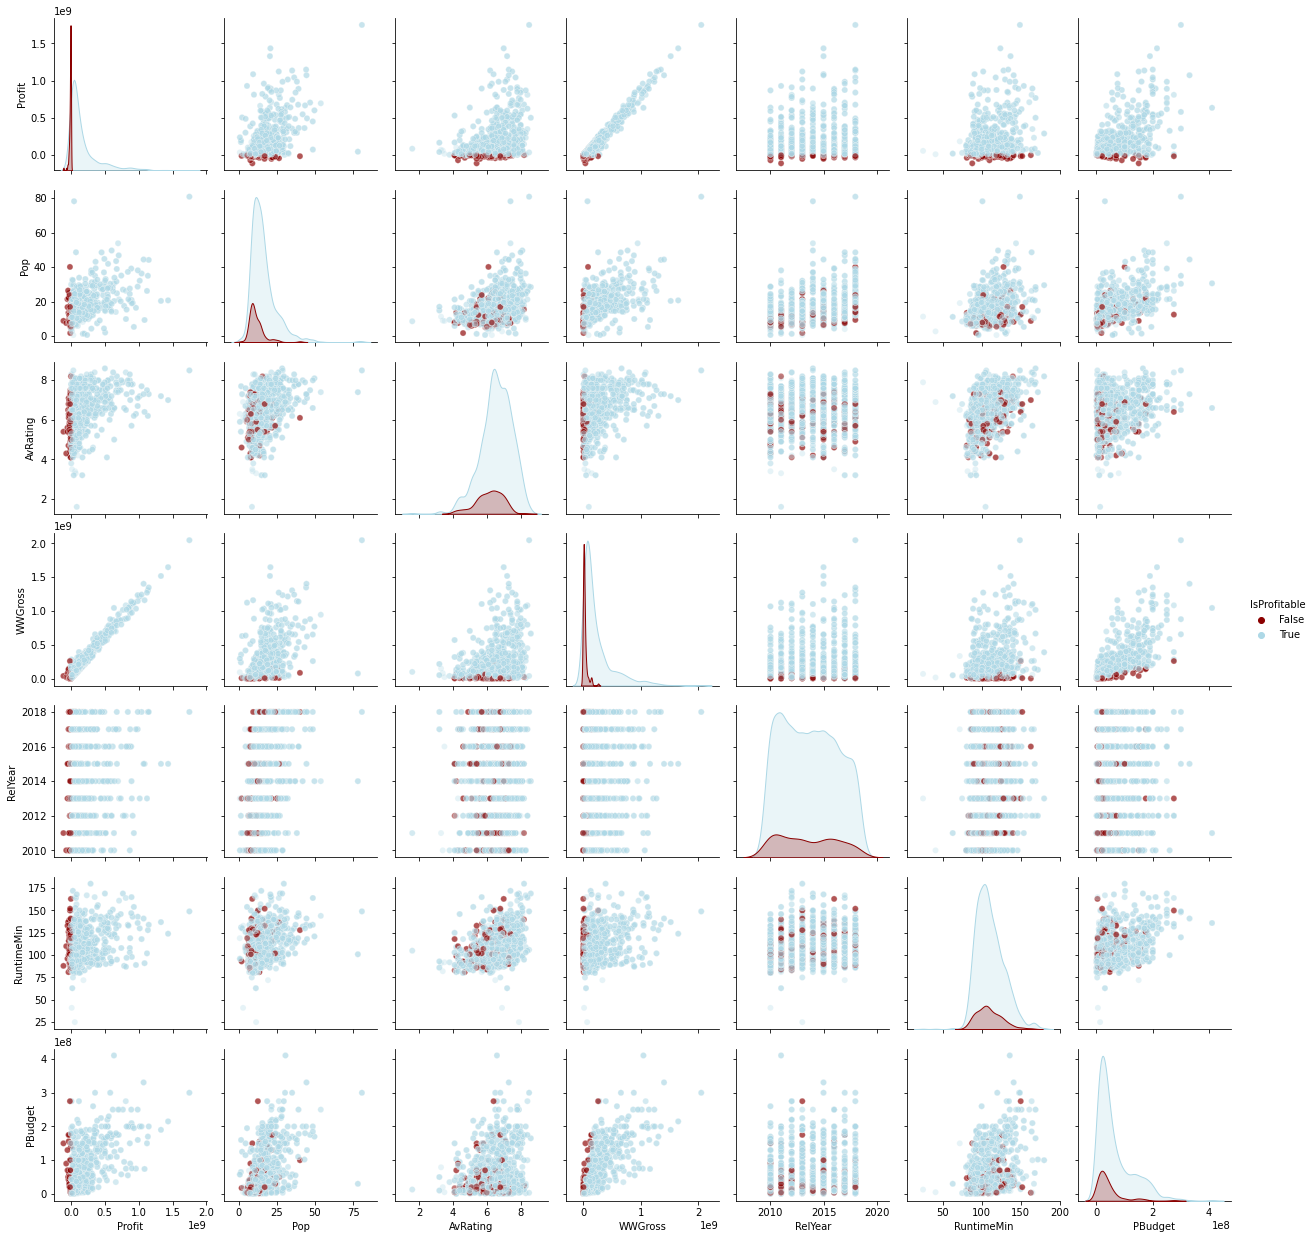

In [64]:
sns.pairplot(dfexplodeexplore, hue='IsProfitable', plot_kws={'alpha':0.3}, palette={True:'lightblue',False:'darkred'})

## Just looking at negative profit

In [65]:
negprofit = dfexplode[dfexplode['Profit'] < 0]
negprofit.head()

,Title,Genres,OL,PBudget,WWGross,Profit,AvRating,RDate,DGrossX,FGrossX,Pop,VoteAv,RuntimeMin,VoteCount,RelYear,Studio,NumVotes,IsProfitable
3,The Legend of Hercules,Action,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
3,The Legend of Hercules,Adventure,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
3,The Legend of Hercules,Fantasy,en,70000000,58953319.0,-11046681.0,4.2,2014-01-10,18848538.0,40104781.0,13.754,4.5,99.0,805.0,2014.0,LG/S,50352,False
22,Aloha,Comedy,en,37000000,25387091.0,-11612909.0,5.4,2015-05-29,21052030.0,4335061.0,9.685,5.3,105.0,1226.0,2015.0,Sony,54646,False
22,Aloha,Drama,en,37000000,25387091.0,-11612909.0,5.4,2015-05-29,21052030.0,4335061.0,9.685,5.3,105.0,1226.0,2015.0,Sony,54646,False


In [66]:
negprofitexplore = negprofit[['Profit','Pop','WWGross','AvRating', 'Genres',
                                'DGrossX','FGrossX','RuntimeMin','Studio','PBudget']]

In [ ]:
sns.pairplot(negprofitexplore)

## Looking at Genres

In [67]:
(dfexplode[df['Genres'].str.contains('Thriller')]).sort_values(by='Profit').tail(30)

<ipython-input-67-4421fbe0f645>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (dfexplode[df['Genres'].str.contains('Thriller')]).sort_values(by='Profit').tail(30)


,Title,Genres,OL,PBudget,WWGross,Profit,AvRating,RDate,DGrossX,FGrossX,Pop,VoteAv,RuntimeMin,VoteCount,RelYear,Studio,NumVotes,IsProfitable
32016,Taken 2,Action,en,45000000,3.778074e+08,3.328074e+08,6.3,2012-10-04,139854287.0,2.379531e+08,16.078,6.2,92.0,4035.0,2012.0,Fox,273106,True
32016,Taken 2,Thriller,en,45000000,3.778074e+08,3.328074e+08,6.3,2012-10-04,139854287.0,2.379531e+08,16.078,6.2,92.0,4035.0,2012.0,Fox,273106,True
18996,Lucy,Thriller,en,40000000,4.575078e+08,4.175078e+08,6.4,2014-07-25,126573960.0,3.309338e+08,16.730,6.3,89.0,10019.0,2014.0,Uni.,403194,True
18996,Lucy,Sci-Fi,en,40000000,4.575078e+08,4.175078e+08,6.4,2014-07-25,126573960.0,3.309338e+08,16.730,6.3,89.0,10019.0,2014.0,Uni.,403194,True
18996,Lucy,Action,en,40000000,4.575078e+08,4.175078e+08,6.4,2014-07-25,126573960.0,3.309338e+08,16.730,6.3,89.0,10019.0,2014.0,Uni.,403194,True
37869,Fast Five,Crime,en,125000000,6.301635e+08,5.051635e+08,7.3,2011-04-28,210031325.0,4.201321e+08,2.097,7.2,130.0,4294.0,2011.0,Uni.,329892,True
37869,Fast Five,Thriller,en,125000000,6.301635e+08,5.051635e+08,7.3,2011-04-28,210031325.0,4.201321e+08,2.097,7.2,130.0,4294.0,2011.0,Uni.,329892,True
37869,Fast Five,Action,en,125000000,6.301635e+08,5.051635e+08,7.3,2011-04-28,210031325.0,4.201321e+08,2.097,7.2,130.0,4294.0,2011.0,Uni.,329892,True
39754,Fifty Shades of Grey,Romance,en,40000000,5.709981e+08,5.309981e+08,4.1,2015-02-13,166167230.0,4.048309e+08,21.229,5.4,125.0,6451.0,2015.0,Uni.,279126,True
39754,Fifty Shades of Grey,Drama,en,40000000,5.709981e+08,5.309981e+08,4.1,2015-02-13,166167230.0,4.048309e+08,21.229,5.4,125.0,6451.0,2015.0,Uni.,279126,True


In [68]:
x = dfexplodeexplore['Genres'].value_counts()
y = x[x > 20].index.tolist()
dfexplodeexploregenres = dfexplodeexplore[dfexplodeexplore['Genres'].isin(y)]
dfexplodeexploregenres.head(1)

,Profit,Pop,Genres,AvRating,WWGross,RelYear,RuntimeMin,IsProfitable,PBudget
3,-11046681.0,13.754,Action,4.2,58953319.0,2014.0,99.0,False,70000000


In [69]:
negprofitexploregenres = dfexplodeexploregenres[dfexplodeexploregenres['Profit'] < 0]
negprofitexploregenres.shape

(308, 9)

In [70]:
print(dfexplodeexplore['Genres'].value_counts())

Drama          410
Comedy         340
Action         305
Adventure      269
Thriller       160
Crime          144
Romance        114
Sci-Fi          94
Horror          88
Biography       82
Animation       82
Mystery         77
Fantasy         77
Family          63
History         26
Music           26
Sport           17
Documentary      8
Western          5
Musical          3
War              3
Name: Genres, dtype: int64


Drama        410
Comedy       340
Action       305
Adventure    269
Thriller     160
Crime        144
Romance      114
Sci-Fi        94
Horror        88
Biography     82
Animation     82
Mystery       77
Fantasy       77
Family        63
History       26
Music         26
Name: Genres, dtype: int64


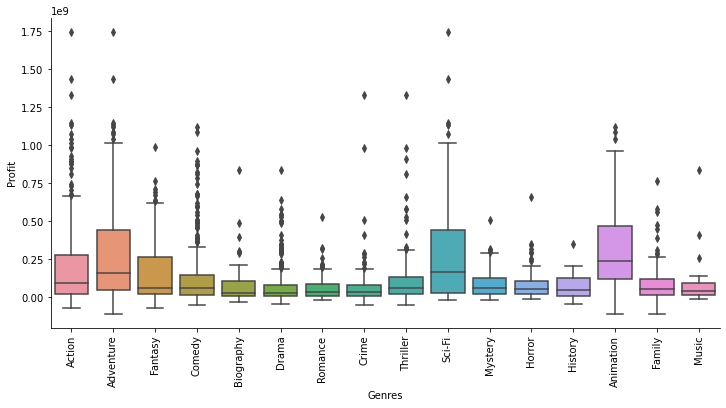

In [71]:
print(dfexplodeexploregenres['Genres'].value_counts())
sns.catplot(data=dfexplodeexploregenres, x='Genres', y = 'Profit', kind='box', height=5, aspect=2)
plt.xticks(rotation=90)
plt.show()

Drama        410
Comedy       340
Action       305
Adventure    269
Thriller     160
Crime        144
Romance      114
Sci-Fi        94
Horror        88
Biography     82
Animation     82
Mystery       77
Fantasy       77
Family        63
History       26
Music         26
Name: Genres, dtype: int64


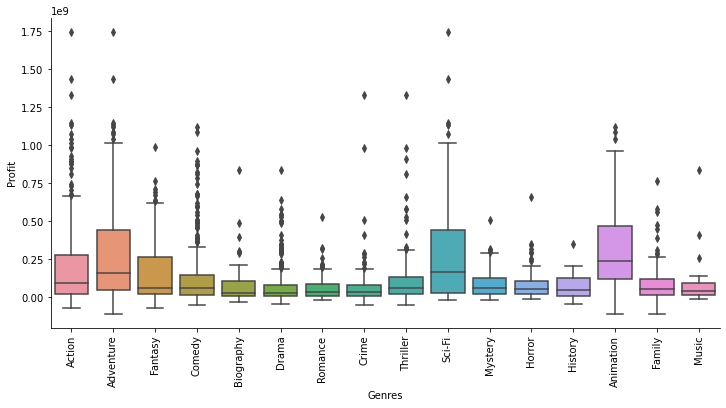

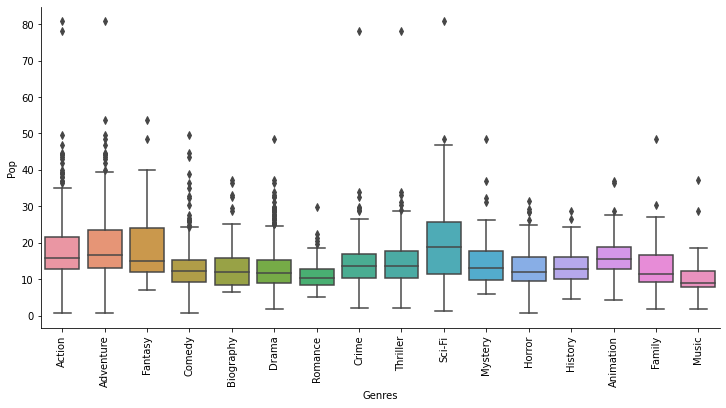

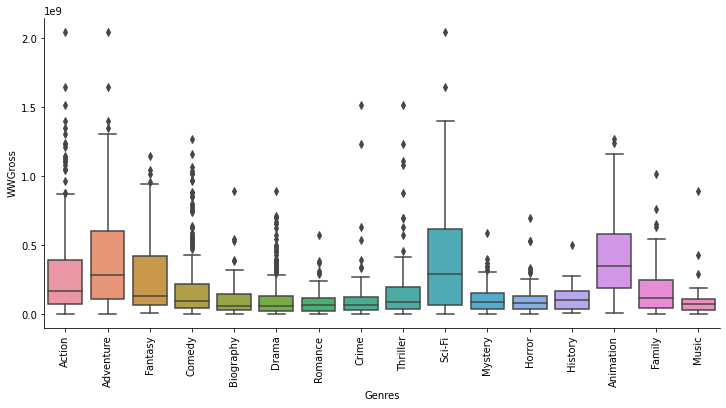

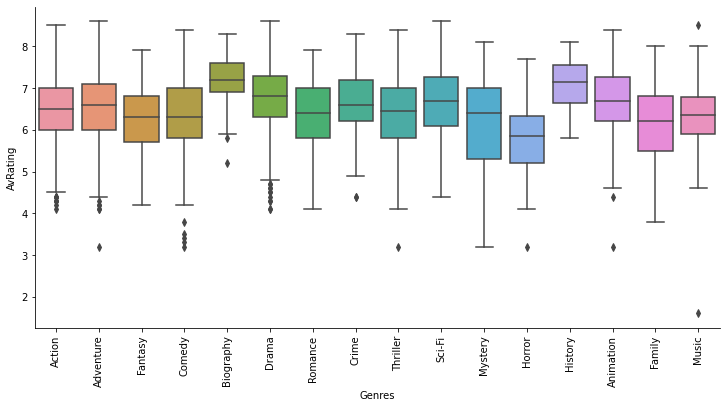

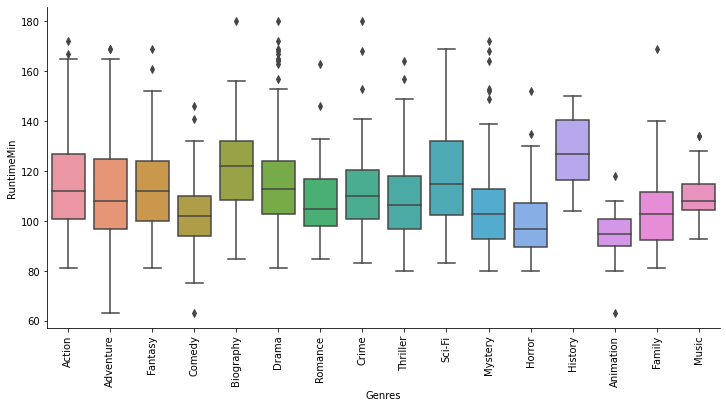

In [72]:
columns = ['Profit','Pop','WWGross','AvRating', 'RuntimeMin']
print(dfexplodeexploregenres['Genres'].value_counts())
for col in columns:
    sns.catplot(data=dfexplodeexploregenres, x='Genres', y = col, kind='box', height=5, aspect=2,)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
dfexplodeexplore.shape

Drama        76
Action       42
Comedy       33
Crime        30
Adventure    23
Thriller     19
Biography    16
Romance      13
Sci-Fi       11
Fantasy      11
Horror        9
Mystery       8
Family        6
History       5
Animation     3
Music         3
Name: Genres, dtype: int64


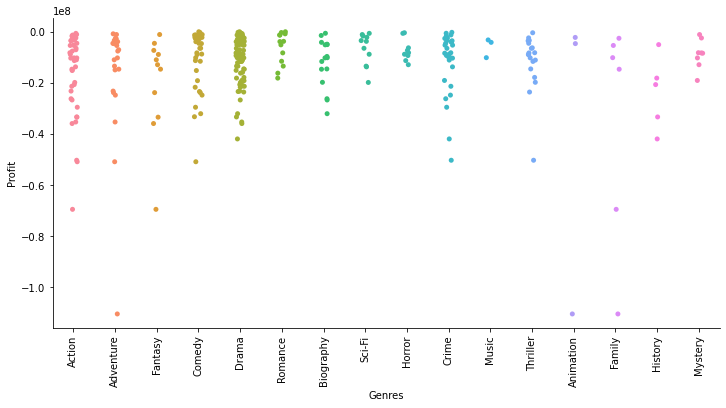

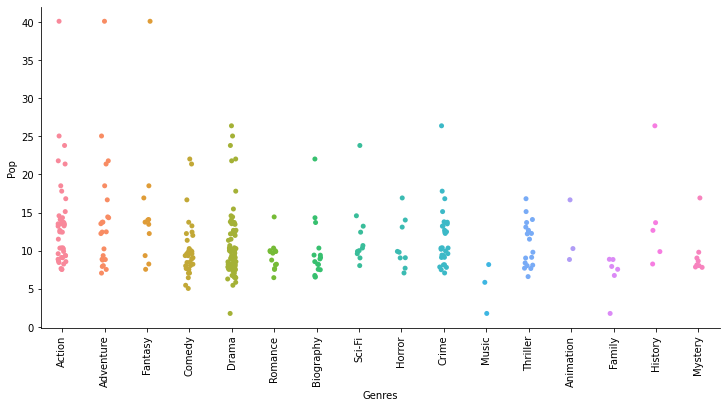

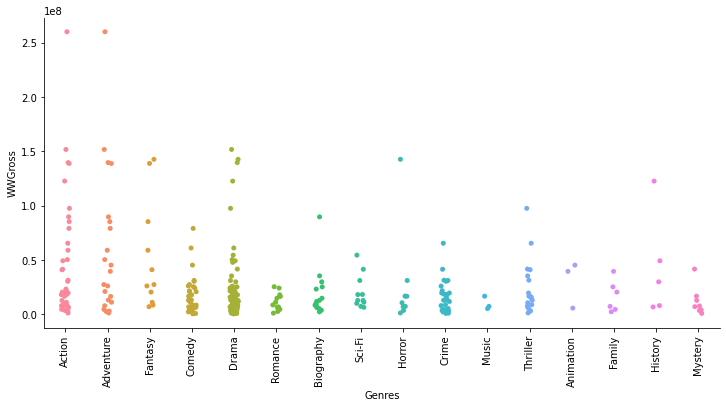

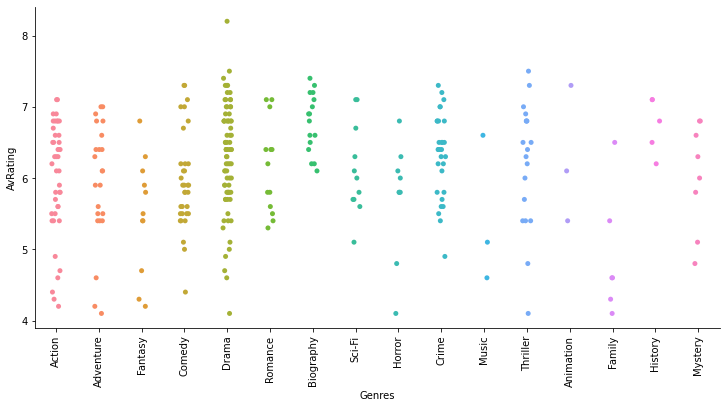

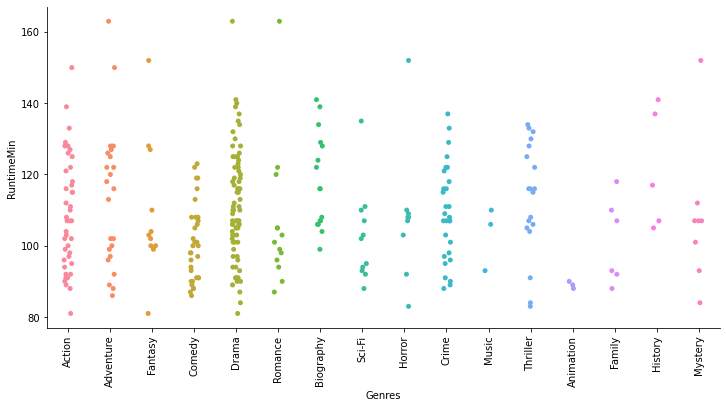

ValueError: Could not interpret input 'Studio'

In [73]:
columns = ['Profit','Pop','WWGross','AvRating', 'RuntimeMin','Studio']
print(negprofitexploregenres['Genres'].value_counts())
for col in columns:
    sns.catplot(data=negprofitexploregenres, x='Genres', y = col, kind='strip', height=5, aspect=2)
    plt.xticks(rotation=90)
    plt.show()

## Lets make these graphs a bit more pretty

In [74]:
pbg = dfexplodeexploregenres.groupby('Genres')['Profit'].median().sort_values(ascending=False)
dfexplodeexploregenres['Genres'] = pd.Categorical(dfexplodeexploregenres['Genres'], categories=pbg.index, ordered=True)
pbg

<ipython-input-74-d3787fe67fc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfexplodeexploregenres['Genres'] = pd.Categorical(dfexplodeexploregenres['Genres'], categories=pbg.index, ordered=True)


Genres
Animation    241270737.0
Sci-Fi       167054362.0
Adventure    161900902.0
Action        91974557.0
Comedy        61689649.5
Mystery       60133905.0
Thriller      60125202.0
Fantasy       57422558.0
Horror        56953436.5
Family        55695194.0
History       48268100.0
Music         38914858.5
Crime         33989778.5
Romance       32805102.0
Drama         29885958.0
Biography     28913641.0
Name: Profit, dtype: float64

In [75]:
dfexplodeexploregenres.groupby('Genres')['Profit'].mean().sort_values(ascending=False)


Genres
Animation    3.257635e+08
Sci-Fi       2.941252e+08
Adventure    2.771487e+08
Action       2.025083e+08
Fantasy      1.755796e+08
Comedy       1.292495e+08
Thriller     1.191629e+08
Family       1.113462e+08
Music        9.697897e+07
Mystery      8.982517e+07
Horror       8.548539e+07
Biography    8.012003e+07
History      7.603357e+07
Crime        7.181980e+07
Drama        6.756017e+07
Romance      6.111323e+07
Name: Profit, dtype: float64

In [76]:
pbg2 = negprofitexploregenres.groupby('Genres')['Profit'].median().sort_values()
negprofitexploregenres['Genres'] = pd.Categorical(negprofitexploregenres['Genres'], categories=pbg2.index, ordered=True)
pbg2

<ipython-input-76-8d27c416baa2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negprofitexploregenres['Genres'] = pd.Categorical(negprofitexploregenres['Genres'], categories=pbg2.index, ordered=True)


Genres
History     -20747239.0
Fantasy     -12965385.0
Family      -12473092.5
Action      -10359888.0
Biography   -10267252.5
Drama        -9207855.5
Thriller     -8957417.0
Mystery      -8415085.5
Crime        -8381399.0
Horror       -8272530.0
Adventure    -7634502.0
Comedy       -6540817.0
Animation    -4714110.0
Music        -4221368.0
Romance      -3924991.0
Sci-Fi       -3826282.0
Name: Profit, dtype: float64

In [78]:
sns.set_theme(style='whitegrid')

Drama        410
Comedy       340
Action       305
Adventure    269
Thriller     160
Crime        144
Romance      114
Sci-Fi        94
Horror        88
Biography     82
Animation     82
Fantasy       77
Mystery       77
Family        63
Music         26
History       26
Name: Genres, dtype: int64


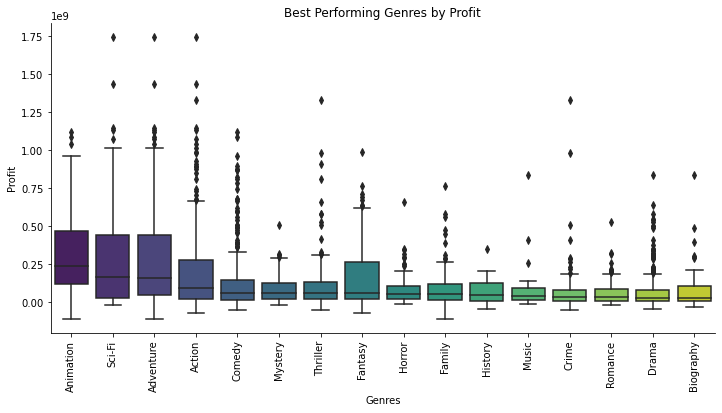

In [77]:
print(dfexplodeexploregenres['Genres'].value_counts())
sns.catplot(data=dfexplodeexploregenres, x='Genres', y = 'Profit', kind='box', height=5, aspect=2, palette='viridis')
plt.xticks(rotation=90)
plt.title('Best Performing Genres by Profit')
plt.show()

Drama        76
Action       42
Comedy       33
Crime        30
Adventure    23
Thriller     19
Biography    16
Romance      13
Sci-Fi       11
Fantasy      11
Horror        9
Mystery       8
Family        6
History       5
Music         3
Animation     3
Name: Genres, dtype: int64


/Users/jamiecarnevale/miniconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jamiecarnevale/miniconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


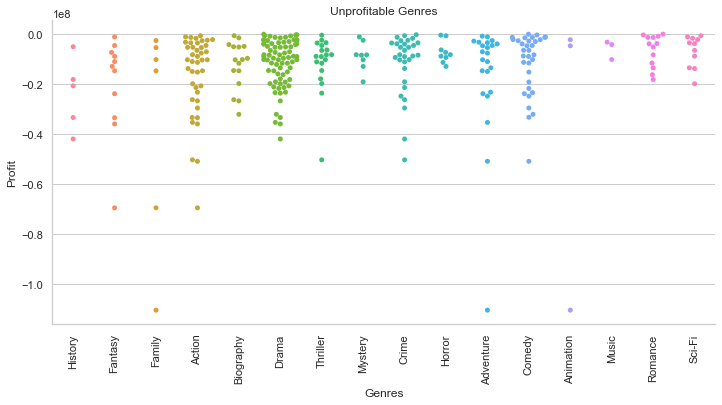

In [79]:
print(negprofitexploregenres['Genres'].value_counts())
sns.catplot(data=negprofitexploregenres, x='Genres', y = 'Profit', kind='swarm', height=5, aspect=2)
plt.title('Unprofitable Genres')
plt.xticks(rotation=90)
plt.show()

# Creating a Graph that tests the Proportionality between Profitable Films and Unprofitable Films by Genre

In [ ]:
#percent of IsProfitable False / IsProfitable.valuecount

In [81]:
dfexplodeexploregenres.groupby('Genres')['IsProfitable'].count()

Genres
Animation     82
Sci-Fi        94
Adventure    269
Action       305
Comedy       340
Mystery       77
Thriller     160
Fantasy       77
Horror        88
Family        63
History       26
Music         26
Crime        144
Romance      114
Drama        410
Biography     82
Name: IsProfitable, dtype: int64

In [82]:
x = dfexplodeexplore['Genres'].value_counts()

In [83]:

x = dfexplodeexploregenres.groupby('Genres')['IsProfitable'].count().sort_values(ascending=False)
y = dfexplodeexploregenres.groupby('Genres')['IsProfitable'].sum().sort_values(ascending=False)
z = (x-y)/x
percentprofit = z.reset_index()
percentprofit.columns = ['Genre', 'PercentNotProfitable']
percentprofit['PercentNotProfitable'] = percentprofit['PercentNotProfitable'] * 100
percentprofit = percentprofit.sort_values(by='PercentNotProfitable', ascending=False)
percentprofit

,Genre,PercentNotProfitable
12,Crime,20.833333
15,Biography,19.512195
10,History,19.230769
14,Drama,18.536585
7,Fantasy,14.285714
3,Action,13.770492
6,Thriller,11.875000
1,Sci-Fi,11.702128
11,Music,11.538462
13,Romance,11.403509


Genres
Animation     82
Sci-Fi        94
Adventure    269
Action       305
Comedy       340
Mystery       77
Thriller     160
Fantasy       77
Horror        88
Family        63
History       26
Music         26
Crime        144
Romance      114
Drama        410
Biography     82
Name: IsProfitable, dtype: int64


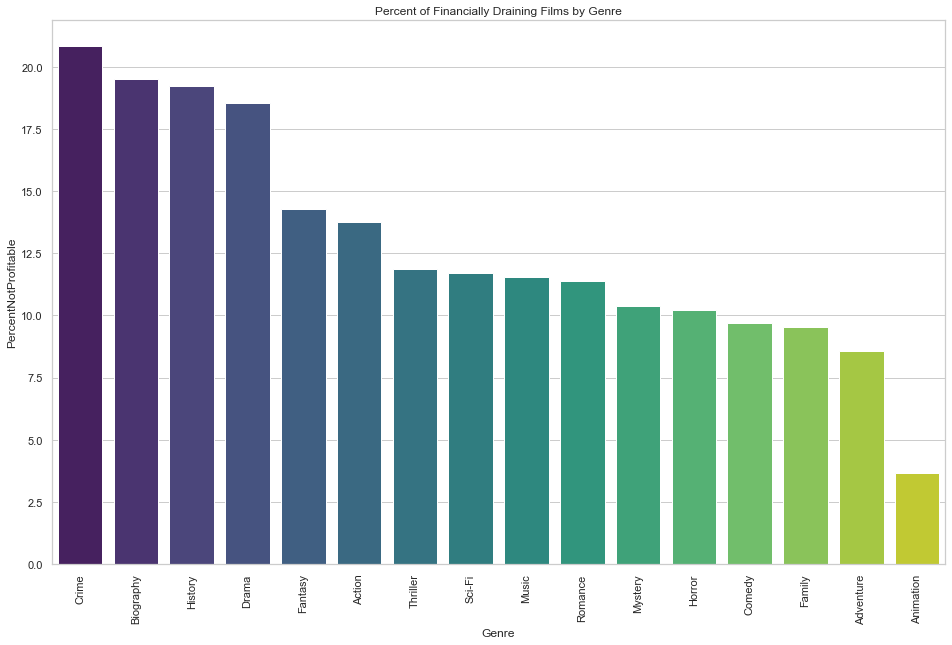

In [84]:
fig, ax =plt.subplots(figsize=(16, 10))
sns.barplot(data=percentprofit, x='Genre', y='PercentNotProfitable', order=percentprofit['Genre'], palette='viridis',ax=ax)
print(dfexplodeexploregenres.groupby('Genres')['IsProfitable'].count())
ax.set_title('Percent of Financially Draining Films by Genre')
plt.xticks(rotation=90)
plt.show()

In [86]:
dfexplodeexploregenres.tail()

,Profit,Pop,Genres,AvRating,WWGross,RelYear,RuntimeMin,IsProfitable,PBudget
73039,15852177.0,10.920,Adventure,4.5,57852177.0,2017.0,90.0,True,42000000
73039,15852177.0,10.920,Comedy,4.5,57852177.0,2017.0,90.0,True,42000000
73243,80378084.0,19.459,Action,7.0,117378084.0,2018.0,100.0,True,37000000
73243,80378084.0,19.459,Comedy,7.0,117378084.0,2018.0,100.0,True,37000000
73243,80378084.0,19.459,Crime,7.0,117378084.0,2018.0,100.0,True,37000000
